# Notebook per download automatico di immagini
L'utilizzo prevede di essere loggati su https://www.sentinel-hub.com/index.html
Il login dovrebbe automaticamente aprire la dashboard, dove si può aggiungere un OAuth client da User settings -> OAuth clients (tab a destra) -> create
Quando il client viene creato compaiono un client ID e un client secret, che vanno copiati e incollati nella cella qua sotto.

Il client ha un limite temporale, se il tentativo di download dà un errore probabilmente è perchè il client è scaduto, ne va creato uno nuovo.

Domande per Chiara:
1. Apparente discrepanza nella risoluzione 10 o 20?
2. Normalize function seems wrong? Do we even need it?

In [ ]:
# Uncomment to run on colab
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/SWAMP'
# SALINA DI CERVIA
#
#geojson_path = 'polygons_geojson/STRETTO_cervia_saltmarsh.geojson'
#f_id = 'Cervia'
#

#ORISTANO - Marceddi
#geojson_path = 'polygons_geojson/STRETTO_marceddi_saltmarsh.geojson'
#f_id = 'Marceddi'
#

#MOLENTARGIUS
#geojson_path = 'polygons_geojson/STRETTO_molentargius_saltmarsh.geojson'
#f_id = 'Molentargius'
#
### TEST CASES ####
#DELTA DEL PO
#geojson_path = 'polygons_geojson/deltaPo.geojson'
#f_id = 'DeltaPo'
#

#LAMONE
#fiume lamone, per l'alluvione dell'Emilia-Romagna dello scorso anno
#geojson_path = 'polygons_geojson/lamone.geojson'
#f_id = 'Lamone'

#
#ortazzino_focebevano
#sito Ramsar con la foce del torrente Bevano, per l'alluvione dell'Emilia-Romagna
#dello scorso anno o in fase di siccità nel 2022
#geojson_path = 'polygons_geojson/ortazzino_focebevano.geojson'
#f_id = 'OrtazzinoFocebevano'

#
#vallecampotto_bassarone_vallesanta
#altro sito Ramsar che include le valli di Campotto, Bassarone e Valle Santa, come sopra.
geojson_path = 'polygons_geojson/vallecampotto_bassarone_vallesanta.geojson'
f_id = 'ValleCampotto'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/flood_data


In [ ]:
!pip install sentinelhub
!pip install matplotlib geopandas

In [ ]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = '1504a94e-4e36-47f7-8439-0e35360d51d6'
config.sh_client_secret = '75P0m1QFppqYNSchtuZI6RI9DtogLwvs'

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import datetime
import os
import scipy.ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

import geopandas as gpd

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
from shapely.geometry import Point
from shapely.prepared import prep
import matplotlib.dates as mdates
import pandas as pd

Queste sono le funzioni che avevo definito nel notebook precedente per normalizzare le bande e calcolare il Modified Normalized Difference Water Index (MNDWI)

In [ ]:
def normalize(band_green, band_swir):
    #Calculate maximum values for each raster file
    max_value = band_green.max()
    max_value = band_swir.max() #This is the same as above - right?

    #Normalize raster data to 0-255 scale
    scaled_band_green = (band_green / max_value) * 255
    scaled_band_swir = (band_swir/ max_value) * 255

    return scaled_band_green, scaled_band_swir


#Calculate MNDWI value for given images
def mndwi(scaled_band_green, scaled_band_swir):
    mndwi = (scaled_band_green - scaled_band_swir) / (scaled_band_green + scaled_band_swir)
    return mndwi

#Calculate turbidity index NDTI
def create_ndti_ras(red_band, green_band):
    ndti = (red_band - green_band)/(red_band + green_band)
    return ndti



## Lettura del file geojson
Qui leggo il file e costruisco un oggetto BBox con le coordinate. Bisogna mettere il path corretto ed eventualmente cambiare il file per cambiare sito.

In [ ]:
# Read the GeoJSON file
gdf = gpd.read_file(geojson_path)

# Extract the bounding box from the GeoDataFrame
minx, miny, maxx, maxy = gdf.total_bounds
bbox = BBox(bbox=[minx, miny, maxx, maxy], crs=CRS.WGS84)

In [ ]:
print(minx, miny, maxx, maxy)

11.7843762 44.5512111 11.8743268 44.6182094


In [ ]:
# resolution=20 corrisponde alla risoluzione 20m, sono i pacchetti che ci interessano perchè hanno anche l'immagine SCL
image_size = bbox_to_dimensions(bbox, resolution=10) #RT fixed at 10m - maybe irrelevant

print(f"Image shape at  m resolution: {image_size} pixels")

Image shape at  m resolution: (688, 769) pixels


## Funzione per richiedere al database l'immagine
Questa è la funzione che scarica i dati da creodias. Sto richiedendo banda 3, banda 11, e SCL. L'output è un dizionario che contiene le due bande e l'immagine SCL. Per ottenere altre bande è sufficiente modificare input, output e return della parte in rosso. `mosaicking_order` permette di selezionare automaticamente le immagini con minore copertura di nuvole, ho inoltre settato una soglia di maximum cloud coverage con `maxcc`

In [ ]:
# Define the request parameters for SCL data
def create_request(date_range):
    return SentinelHubRequest(
        data_folder='./temp_data/',
        evalscript="""
            //VERSION=3
            function setup() {
                return {
                    input: ["B03", "B04", "B11", "SCL"],
                    output: [
                        { id: "bands", bands: 3, sampleType: SampleType.FLOAT32 },
                        { id: "scl", bands: 1, sampleType: SampleType.UINT8 }
                    ]
                };
            }
            function evaluatePixel(sample) {
                return {
                    bands: [sample.B03*10000, sample.B04*10000, sample.B11*10000],
                    scl: [sample.SCL]
                };
            }
        """,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=date_range,
                mosaicking_order='leastCC',
                maxcc=0.05  # Maximum cloud coverage of 5%
            )
        ],
        responses=[
            SentinelHubRequest.output_response('bands', MimeType.TIFF),
            SentinelHubRequest.output_response('scl', MimeType.TIFF)
        ],
        bbox=bbox,
        size=bbox_to_dimensions(bbox, resolution=10),
        config=config
    )

A questo punto specifico un time range a cui fare riferimento, e poi uso la funzione `create_request` definita sopra e salvo il dizionario risultante in `image_data`:

In [ ]:
# Request SCL data for a specific date range
date_range = ('2020-05-01', '2024-05-31')
request = create_request(date_range)
image_data = request.get_data()[0]

In [ ]:
image_data.keys()

dict_keys(['bands.tif', 'scl.tif'])

In [ ]:
band_b03 = image_data['bands.tif'][:, :, 0]
band_b04 = image_data['bands.tif'][:, :, 1]
band_b11 = image_data['bands.tif'][:, :, 2]
print(band_b03.max(), band_b04.max(), band_b11.max())
band_green_b, band_swir_b = normalize(band_b03, band_b11)
print(band_green_b.max(),  band_swir_b.max())

6812.0 7132.0 7561.0
229.73946 255.0


In [ ]:
def create_mask(ndti_flipped, boundary, mask_w):
    minx, miny, maxx, maxy = boundary.geometry.total_bounds
    prepared_boundary = prep(boundary.geometry.iloc[0])

    # Create coordinate grids
    x, y = np.meshgrid(
        np.linspace(minx, maxx, ndti_flipped.shape[1]),
        np.linspace(miny, maxy, ndti_flipped.shape[0])
    )

    # Create points from coordinate grids and check if they are within the boundary and satisfy mask_w condition
    mask = np.array([prepared_boundary.contains(Point(x_coord, y_coord)) and mask_w_value
                     for x_coord, y_coord, mask_w_value in zip(x.flatten(), y.flatten(), mask_w.flatten())])  # List Comprehension here

    # Reshape the mask to match ndti_flipped
    return mask.reshape(ndti_flipped.shape)

def create_mask_boundary(ndti_flipped, boundary):
    minx, miny, maxx, maxy = boundary.geometry.total_bounds
    prepared_boundary = prep(boundary.geometry.iloc[0])

    # Create coordinate grids
    x, y = np.meshgrid(
        np.linspace(minx, maxx, ndti_flipped.shape[1]),
        np.linspace(miny, maxy, ndti_flipped.shape[0])
    )

    # Create points from coordinate grids and check if they are within the boundary and satisfy mask_w condition
    mask = np.array([prepared_boundary.contains(Point(x_coord, y_coord))
                     for x_coord, y_coord in zip(x.flatten(), y.flatten())])  # List Comprehension here

    # Reshape the mask to match ndti_flipped
    return mask.reshape(ndti_flipped.shape)



## Plot dell'immagine


The Normalize Difference Turbidity Index (NDTI) which is estimated using the spectral reflectance values of the water pixels is used to estimate the turbidity in water bodies. It uses the phenomenon that the electromagnetic reflectance is higher in green spectrum than the red spectrum for clear water. Hence, with increase in turbidity the reflectance of red spectrum also increases. Accordingly, in the current study, Sentinel-2 green (band 3) and red (band 4) bands are used to create the NDTI raster in the following.
Source: https://developers.arcgis.com/python/samples/river-turbidity-estimation-using-sentinel2-data-/

In [ ]:
def plot_images(image_data, date_range, water_stats, boundary, f_id=''):
  # Separate the bands and SCL images
  bands_image = image_data['bands.tif']
  scl_image = image_data['scl.tif']
  # Extract the bands
  band_b03 = bands_image[:, :, 0]
  band_b04 = bands_image[:, :, 1]
  band_b11 = bands_image[:, :, 2]
  scl_data = scl_image

  mndwi_b = mndwi(band_b03, band_b11)
  ndti = create_ndti_ras(red_band = band_b04, green_band = band_b03)
  # Define a colormap that transitions from white to light green to blue to dark navy blue
  colors = [(1, 1, 1), (0.8, 1, 0.8), (0, 0, 1), (0, 0, 0.4)]  # (R, G, B)
  cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
  cmap_gyr = LinearSegmentedColormap.from_list('green_yellow_red', ['green', 'yellow', 'red'])  # Create custom colormap
  colors_bwr = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # (R, G, B)
  cmap_bwr = LinearSegmentedColormap.from_list('blue_white_red', colors_bwr, N=256)

  vmin, vmax = -1, 1
  water_th = 0.0
  mask_w = mndwi_b > water_th
  color = (0, 0, 255)  # Water color
  MNDWI_colored = np.ones((scl_data.shape[0], scl_data.shape[1], 3), dtype=np.uint8)*255
  MNDWI_colored[mask_w] = color
  defective_fraction = (np.sum(scl_data==0) + np.sum(scl_data==1))/scl_data.size

  # Extract the coordinates of the boundary polygon
  x, y = boundary.geometry.iloc[0].exterior.xy
  # Get the extent of the boundary for pcolormesh
  minx, miny, maxx, maxy = boundary.geometry.total_bounds
  # Create a prepared geometry for efficient point-in-polygon checks
  prepared_boundary = prep(boundary.geometry.iloc[0])
  # Flip the ndti array about the y-axis
  ndti_flipped = np.flip(ndti, axis=0)
  mndwi_b_flipped = np.flip(mndwi_b, axis=0)
  #Water mask - flipped about y-axis
  mask_w = np.flip(mndwi_b, axis=0) > 0.0
  # Create a mask based on points within the boundary AND with water>0
  mask = create_mask(ndti_flipped, boundary, mask_w)
  # Create a mask based on points within the boundary ONLY
  mask_boundary = create_mask_boundary(ndti_flipped, boundary)
  # Apply the mask to the flipped NDTI data
  ndti_flipped_masked = np.ma.masked_array(ndti_flipped, mask=(~mask) )
  mndwi_b_flipped_masked_boundary = np.ma.masked_array(mndwi_b_flipped, mask=(~mask_boundary) )
  mndwi_b_flipped_masked = np.ma.masked_array(mndwi_b_flipped, mask=(~mask) )
  turbidity_average = np.mean(ndti_flipped_masked)
  turbidity_max = np.max(ndti_flipped_masked)
  turbidity_std = np.std(ndti_flipped_masked)
  water_fraction = np.sum(mndwi_b_flipped_masked>water_th)/mask_w.size
  cloud_fraction = (np.sum(scl_data==7)+np.sum(scl_data==8)+np.sum(scl_data==9))/scl_data.size
# Print water stats
  print(f"Water fraction: {water_fraction:.2f}, Cloud fraction: {cloud_fraction:.2f}, Defective fraction: {defective_fraction:.2f},\
  Turbidity av: {turbidity_average:.2f}, Turbidity max: {turbidity_max:.2f} ")


  # Plot non defective images images
  if (defective_fraction < 0.1):
    water_stats.append([date_range[0], water_fraction, cloud_fraction, defective_fraction, turbidity_average, turbidity_std, turbidity_max])
    fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharey= True)
    fig.subplots_adjust(hspace=0.5)  # Add vertical spacing between rows
    #plots the MNDWI map
    im=ax[0,0].pcolormesh(np.linspace(minx, maxx, ndti_flipped.shape[1]),
               np.linspace(miny, maxy, ndti_flipped.shape[0]),
               mndwi_b_flipped_masked_boundary,
               cmap=cmap, vmin=vmin, vmax=vmax)
    # Plot the boundary polygon
    ax[0,1].plot(x, y, color='red', linewidth=2)
    ax[0,0].set_title(f"Site: {f_id}, {date_range[0]} to {date_range[1]}", fontsize=12)
    ax[0,0].axis('off')
    fig.subplots_adjust(wspace=0.05, right=0.8)  # Reduce space between axes and make room for colorbar
    cbar_ax = fig.add_axes([0.15, 0.50, 0.22, 0.015])  # Position and size of colorbar [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='MNDWI (water index)')

    # TURBIDITY MAP - within bounday

    # Plot the MNDWI data using pcolormesh with correct extent
    im2=ax[0,1].pcolormesh(np.linspace(minx, maxx, ndti_flipped.shape[1]),
               np.linspace(miny, maxy, ndti_flipped.shape[0]),
               ndti_flipped_masked,
               cmap=cmap_gyr, vmin=vmin, vmax=vmax)
    # Plot the boundary polygon
    ax[0,1].plot(x, y, color='red', linewidth=2)

    # Set axis labels and title
    ax[0,1].set_xlabel('Longitude')
    ax[0,1].set_ylabel('Latitude')
    ax[0,1].set_title('Water-masked NDTI with Boundary Overlay')

    cbar_ax = fig.add_axes([0.50, 0.50, 0.22, 0.015])  # Position and size of colorbar [left, bottom, width, height]
    fig.colorbar(im2, cax=cbar_ax, orientation='horizontal', label='NDTI (turbidity index)')


    # Get kernel width from user
    kernel_width = 10
    vmin_bwr = -3; vmax_bwr = 3

    # Apply Gaussian smoothing
    ndti_smoothed = ndi.gaussian_filter((ndti_flipped_masked-np.average(ndti_flipped_masked))/np.std(ndti_flipped_masked), sigma=kernel_width)
    ndti_smoothed_masked = np.ma.masked_array(ndti_smoothed, mask=~mask)
    im3=ax[1,1].pcolormesh(np.linspace(minx, maxx, ndti_flipped.shape[1]),
               np.linspace(miny, maxy, ndti_flipped.shape[0]),
               ndti_smoothed_masked,
               cmap=cmap_bwr, vmin=vmin_bwr, vmax=vmax_bwr)
    idx_max = np.unravel_index(np.argmax(ndti_smoothed_masked), ndti_smoothed.shape)
    #  Create coordinate grids
    x, y = np.meshgrid(
    np.linspace(minx, maxx, ndti_smoothed_masked.shape[1]),
    np.linspace(miny, maxy, ndti_smoothed_masked.shape[0]))
    ax[1,1].scatter(x[idx_max], y[idx_max], marker='x', s=100, color='black', linewidths=2)
    cbar_ax = fig.add_axes([0.50, 0.05, 0.22, 0.015])  # Position and size of colorbar [left, bottom, width, height]
    fig.colorbar(im3, cax=cbar_ax, orientation='horizontal', label='Departure from average (sigma)')
    ax[1,1].set_xlabel('Longitude')
    ax[1,1].set_ylabel('Latitude')
    # Delete the bottom left axis
    fig.delaxes(ax[1, 0])

    if (f_id != ''):
      fname=f"output_images/{f_id}_{date_range[0]}_{date_range[1]}.png"
      plt.savefig(fname)
    plt.show()



Water fraction: 0.11, Cloud fraction: 0.03, Defective fraction: 0.00,  Turbidity av: -0.17, Turbidity max: 0.09 


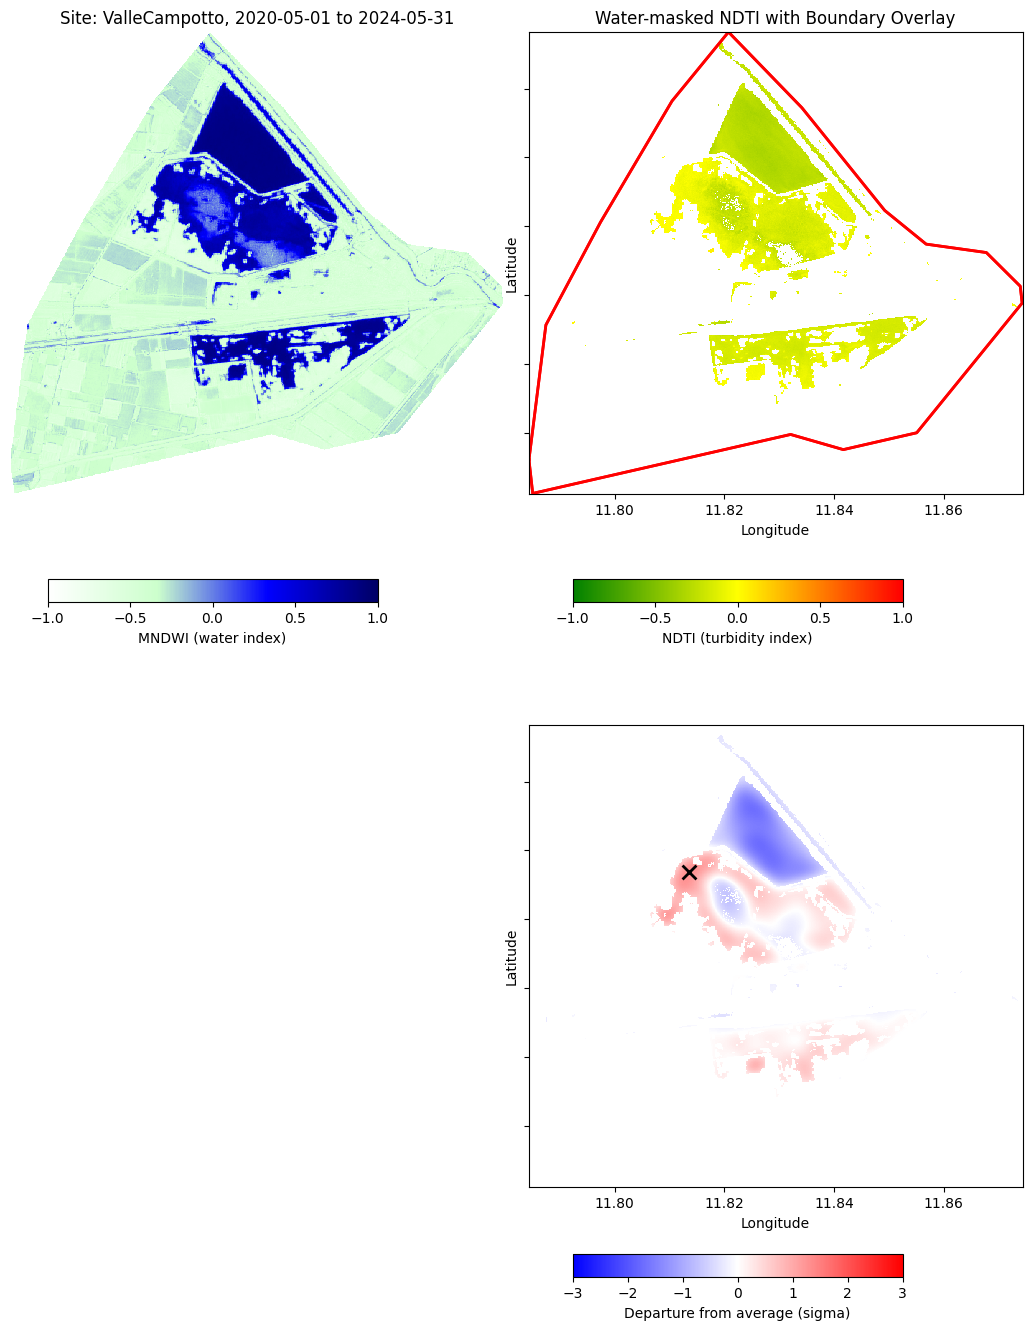

In [ ]:
stats_over_time=[]
plot_images(image_data, date_range, stats_over_time, gdf, f_id)

# Download multipli
Qui utilizzo un approccio simile a sopra, ma applicato a un range temporale molto più lungo. `start` e `end` sono inizio e fine del range temporale, `n_chunks` corrisponde circa al numero di mesi considerato, per suddividere ulteriormente in slot.

In [ ]:
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 6, 1)
num_months = (end.year - start.year) * 12 + (end.month - start.month)
n_chunks = num_months
print(f"Number of chunks: {n_chunks}")
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

Number of chunks: 77


In [ ]:
# Le date possono anche essere definite così, se ad esempio si vogliono slot temporali discontinue:
# dates = [
#     ('2023-01-01', '2023-01-31'),
#     ('2023-02-01', '2023-02-28'),
#     ('2023-03-01', '2023-03-31'),
#     # Add more dates as needed
# ]

In [ ]:
# create a list of requests
list_of_requests = [create_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [ ]:
print(f"Number of chunks: {n_chunks} and number of tiles: {len(data)}")
print(f"Missing tiles: {n_chunks-len(data)}")


Number of chunks: 77 and number of tiles: 76
Missing tiles: 1


Water fraction: 0.07, Cloud fraction: 0.63, Defective fraction: 0.00,  Turbidity av: -0.08, Turbidity max: 0.09 


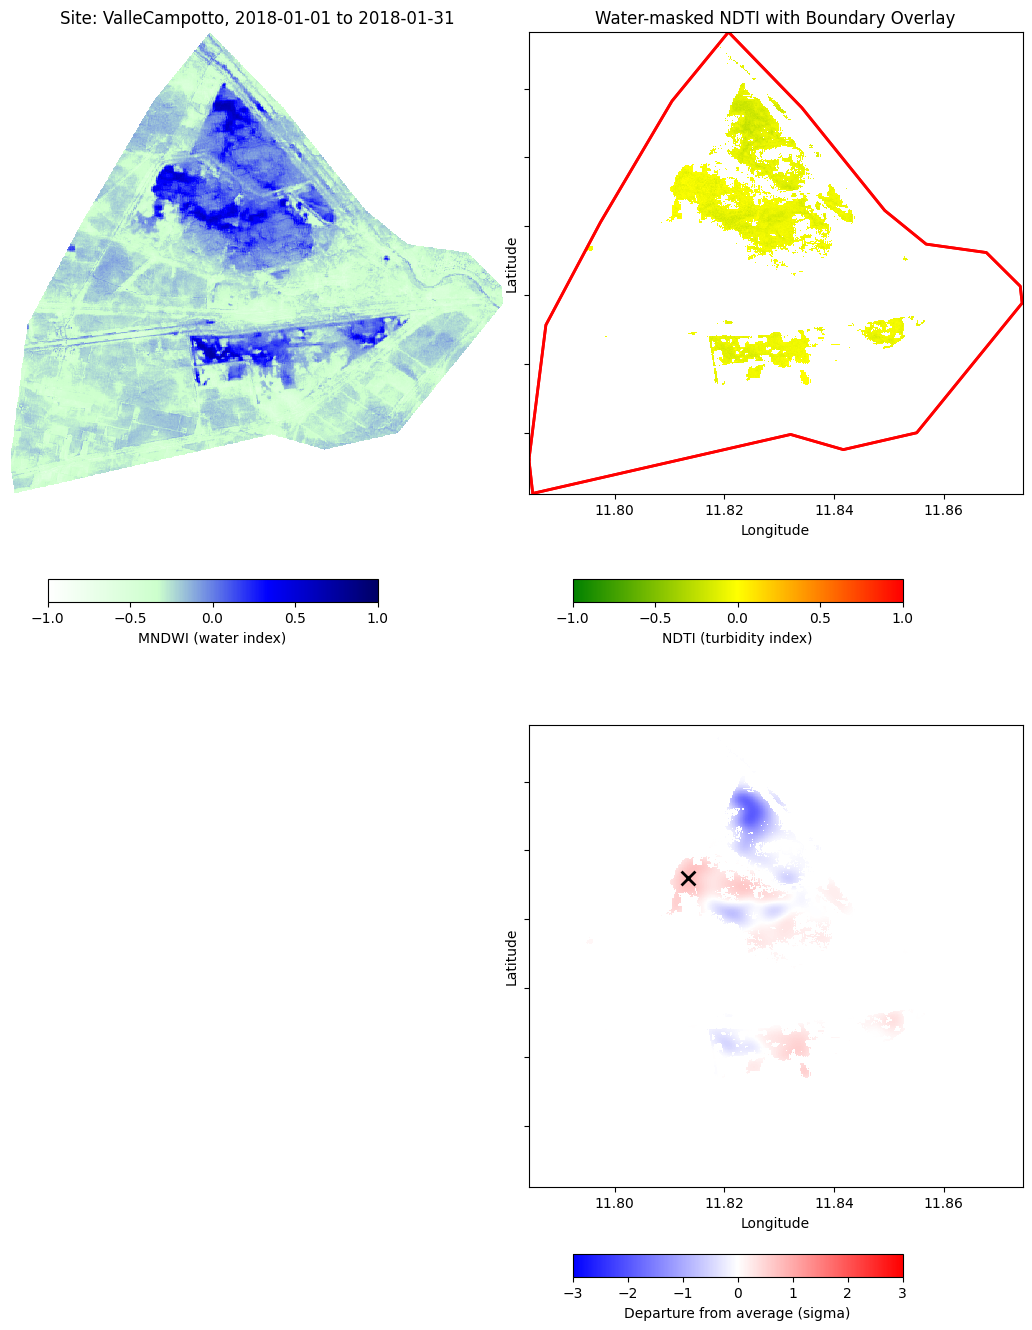

<ipython-input-31-be2161aa6df1>:15: RuntimeWarning: invalid value encountered in divide
  mndwi = (scaled_band_green - scaled_band_swir) / (scaled_band_green + scaled_band_swir)
<ipython-input-31-be2161aa6df1>:20: RuntimeWarning: invalid value encountered in divide
  ndti = (red_band - green_band)/(red_band + green_band)
<ipython-input-40-ae1eaac8b8eb>:53: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  print(f"Water fraction: {water_fraction:.2f}, Cloud fraction: {cloud_fraction:.2f}, Defective fraction: {defective_fraction:.2f},\


Water fraction: --, Cloud fraction: 0.00, Defective fraction: 1.00,  Turbidity av: --, Turbidity max: -- 
Water fraction: --, Cloud fraction: 0.00, Defective fraction: 1.00,  Turbidity av: --, Turbidity max: -- 
Water fraction: 0.11, Cloud fraction: 0.20, Defective fraction: 0.00,  Turbidity av: -0.12, Turbidity max: 0.13 


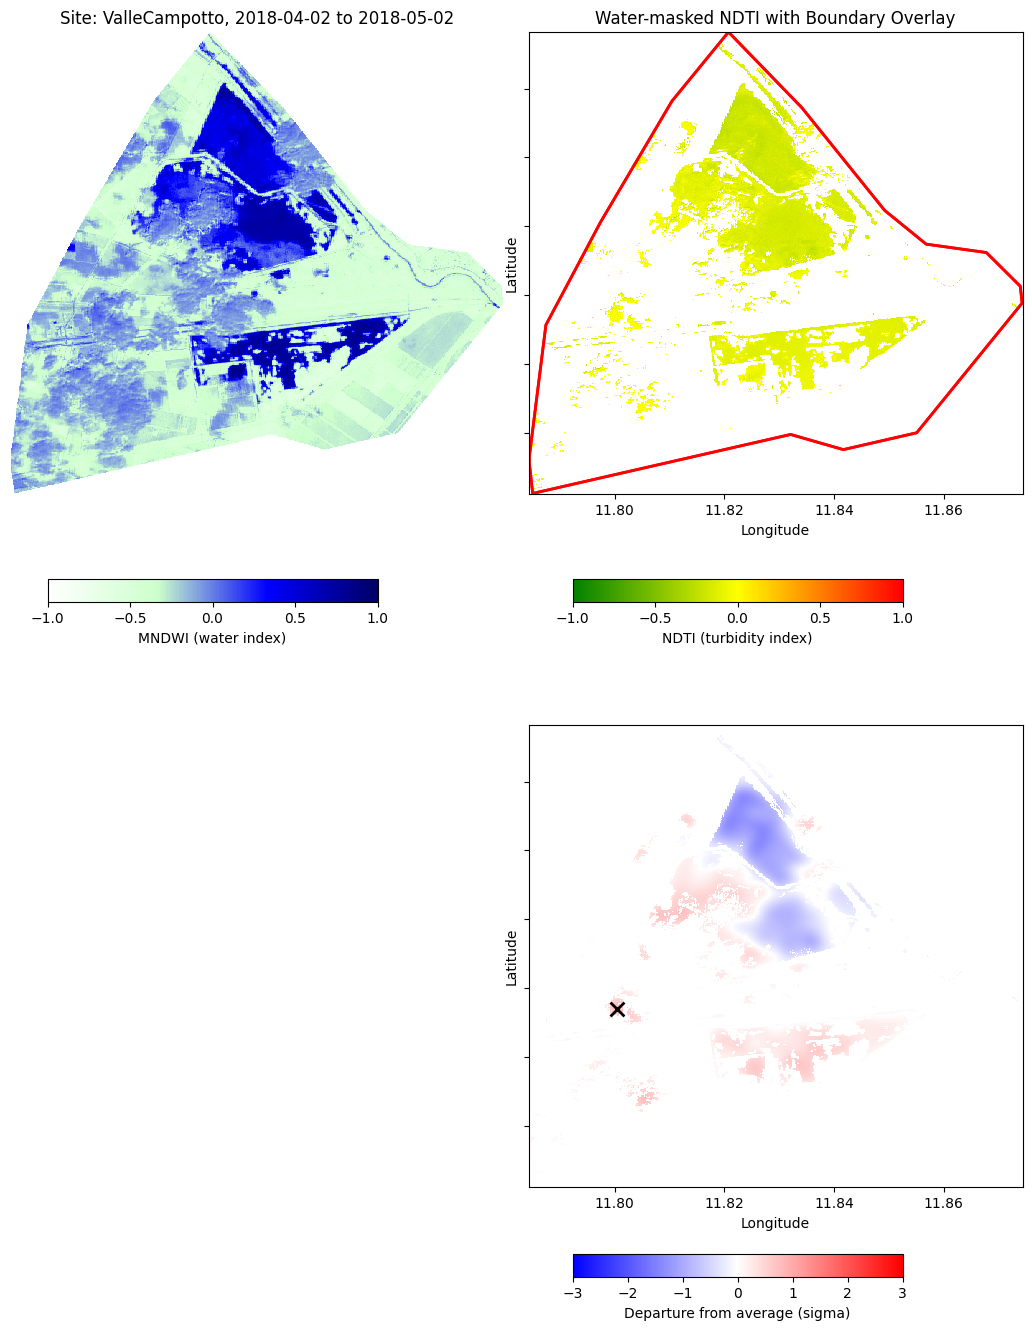

Water fraction: --, Cloud fraction: 0.00, Defective fraction: 1.00,  Turbidity av: --, Turbidity max: -- 


In [ ]:
# Plot delle immagini
stats_over_time_multiple=[]
for idx, image in enumerate(data):
   plot_images(image, slots[idx], stats_over_time_multiple, gdf, f_id)


In [ ]:
#gets summary stats into variables
dates, water_fraction, cloud_fraction, defective_fraction, turbidity_average, turbidity_std, turbidity_max  = zip(*stats_over_time_multiple)
dates = pd.to_datetime(dates)



In [ ]:
np.shape(stats_over_time_multiple)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average turbidity with error bars on the first y-axis
ax1.errorbar(dates, turbidity_average, yerr=turbidity_std, fmt='-o', capsize=5, color='green', label='Average Turbidity')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Turbidity')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)
# Add scatter plot of turbidity_max
ax1.scatter(np.array(dates), turbidity_max, marker='x', color='black', label='Maximum Turbidity')
ax1.set_xlim([min(dates), max(dates)])
# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot water fraction on the second y-axis
ax2.plot(np.array(dates), np.array(water_fraction), marker='o', color='b', label=r'Water fraction', alpha=0.5)
ax2.set_ylabel('Water Fraction')

# Format the x-axis with fewer ticks and rotate labels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation=45)
plt.grid(True)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Turbidity/Water over Time')
plt.tight_layout()
plt.show()
fname=f"output_images/{f_id}_CombinedStats_Over_Time.png"
plt.savefig(fname)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ... (previous code) ...

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average turbidity with error bars on the first y-axis
ax1.errorbar(dates, turbidity_average, yerr=turbidity_std, fmt='-o', capsize=5, color='green', label='Average Turbidity')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Turbidity')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)
# Add scatter plot of turbidity_max
ax1.scatter(np.array(dates), turbidity_max, marker='x', color='black', label='Maximum Turbidity')
ax1.set_xlim([min(dates), max(dates)])

# Calculate average turbidity and standard deviation
avg_turbidity = np.mean(turbidity_average)
std_turbidity = np.std(turbidity_average)

# Add horizontal band for average turbidity with shaded standard deviation
ax1.axhspan(avg_turbidity - std_turbidity, avg_turbidity + std_turbidity, color='gray', alpha=0.3, label='Average Turbidity ± Std Dev')

# Scale water fraction values to fit on the same axis
scaling_factor = (max(turbidity_average)-min(turbidity_average)) / (max(water_fraction)-min(water_fraction))
scaled_water_fraction = [val * scaling_factor for val in water_fraction]

# Plot water fraction
center_y = -0.56  # Center of the y-axis for water
ax1.plot(np.array(dates), np.array(scaled_water_fraction)-np.average(scaled_water_fraction)+center_y, marker='o', color='b', label=r'Scaled water fraction', alpha=0.5)
# Calculate average water fraction and standard deviation
std_water_fraction = np.std(scaled_water_fraction)

# Add horizontal band for average water fraction with shaded standard deviation
ax1.axhspan(center_y - std_water_fraction, center_y + std_water_fraction,
            color='blue', alpha=0.1, label='Average Water Fraction ± Std Dev')

# Format the x-axis and add grid
fig.autofmt_xdate()
plt.grid(True)
# Set x-axis major locator to show labels every 3 months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Extract years from the dates
years = pd.DatetimeIndex(dates).year.unique()

# Plot thicker vertical lines for January 1st of each year
for year in years:
    jan_date = pd.to_datetime(f"{year}-01-01")
    plt.axvline(jan_date, color='black', linestyle='-', linewidth=1.5)  # Adjust linewidth as desired


# Enable minor grid for x-axis to show lines every 3 months
plt.grid(True, which='both', axis='x')


# Add legend
ax1.legend(loc='upper left')

ax1.set_title(f'{f_id} Turbidity over Time')
plt.tight_layout()
fname=f"output_images/{f_id}_CombinedStats_Over_Time.png"
plt.savefig(fname)
plt.show()
